In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

samp_rate = 100
n_avg = 1000
T_avg = n_avg/samp_rate

In [2]:
def load_timeseries(filename, freq_tune = 65, freq_correct = 0, skip = 0):
    phase = np.fromfile(filename, dtype = 'float32')
    t_start = np.datetime64(filename.split('_')[-1].rstrip('.f32'))
    phase_correct = (freq_correct/samp_rate * 2 * np.pi * np.arange(phase.size)) % (2*np.pi)\
        if freq_correct != 0 else 0
    t = t_start + np.arange(0, phase.size, n_avg) * np.timedelta64(int(1e9/samp_rate), 'ns')
    f = np.diff(np.unwrap(phase + phase_correct)[::n_avg])/(2*np.pi*T_avg) + freq_tune
    return xr.DataArray(np.concatenate((f[skip:], [np.nan])), # note we insert a nan at the end to break up the series
                        coords = {'time' : t[skip:]}, dims = ('time'))

In [3]:
f = xr.concat((load_timeseries('phase_bpsk_2020-04-09T15:31:07.376113.f32', freq_correct = -25),
               load_timeseries('phase_bpsk_2020-04-10T08:59:32.991039.f32', skip = 7),
               load_timeseries('phase_bpsk_2020-04-11T08:05:47.727518.f32', skip = 8),
               load_timeseries('phase_bpsk_2020-04-11T19:59:53.454352.f32', skip = 7),
               load_timeseries('phase_bpsk_2020-04-12T13:39:29.030021.f32', skip = 1),
               load_timeseries('phase_bpsk_2020-04-14T06:08:03.109027.f32', skip = 7),
               load_timeseries('phase_bpsk_2020-04-16T20:29:07.486691.f32', skip = 3),
               load_timeseries('phase_bpsk_2020-04-17T12:08:22.150961.f32', skip = 0)
              ), 'time')

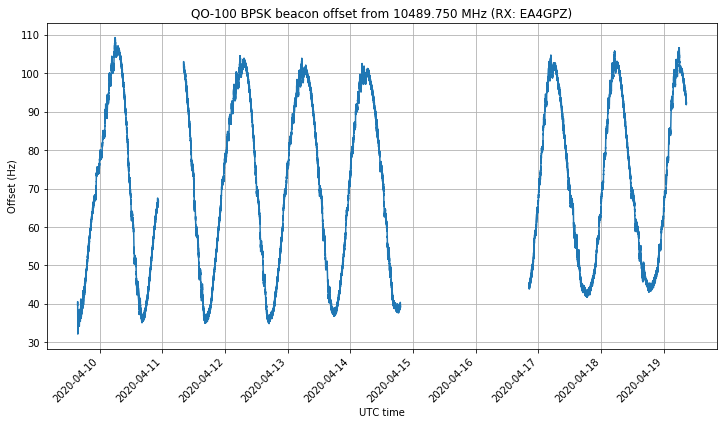

In [4]:
plt.figure(figsize = (12,6), facecolor = 'w')

f.plot()

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid()

# eclipse calculator https://www.satellite-calculations.com/Satellite/satellite_eclipse.htm

#plt.axvspan(np.datetime64('2020-04-09T22:04:35'), np.datetime64('2020-04-09T22:31:40'),
#            color = 'grey', alpha = 0.3, label = 'Eclipse')
#plt.axvspan(np.datetime64('2020-04-10T22:08:33'), np.datetime64('2020-04-10T22:27:10'),
#            color = 'grey', alpha = 0.3)
#plt.legend();

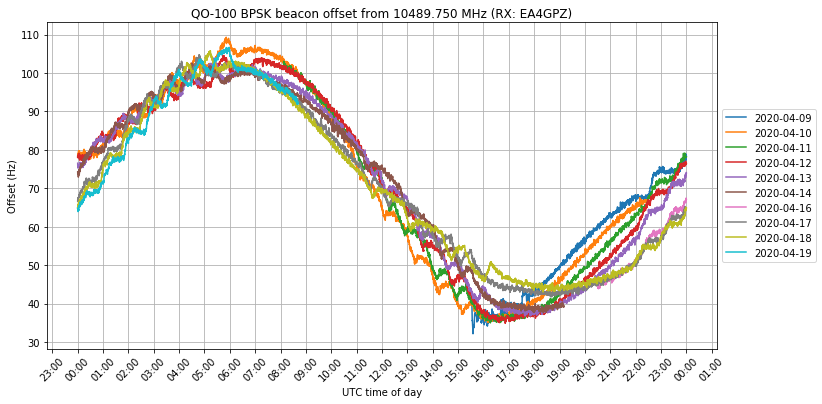

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = 0

for j,d in enumerate(f.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    plt.plot(time_of_day, d[1] - offset_by_day*j, label = d[0].astype('datetime64[D]'))

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time of day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

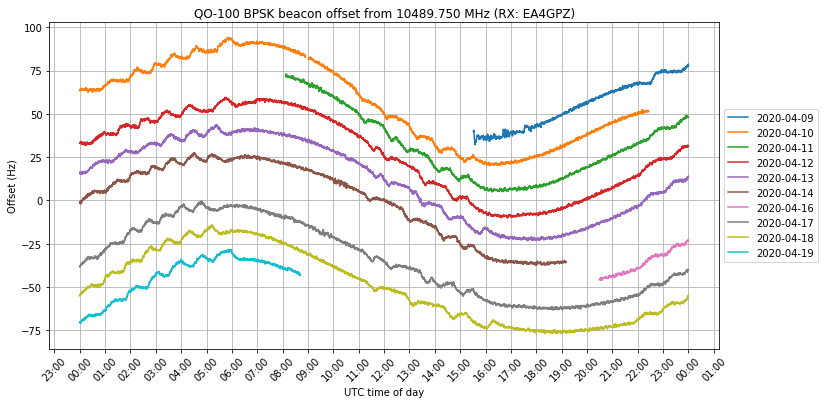

In [6]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = 15

for j,d in enumerate(f.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    plt.plot(time_of_day, d[1] - offset_by_day*j, label = d[0].astype('datetime64[D]'))

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time of day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [7]:
bpsk = load_timeseries('phase_bpsk_2020-04-12T13:39:29.030021.f32', skip = 1).\
    sel(time = slice('2020-04-12', '2020-04-12T16:45:00'))
ea4gpz_cw = load_timeseries('phase_2020-04-12T13:40:13.670776.f32', freq_tune = 50, skip = 3)

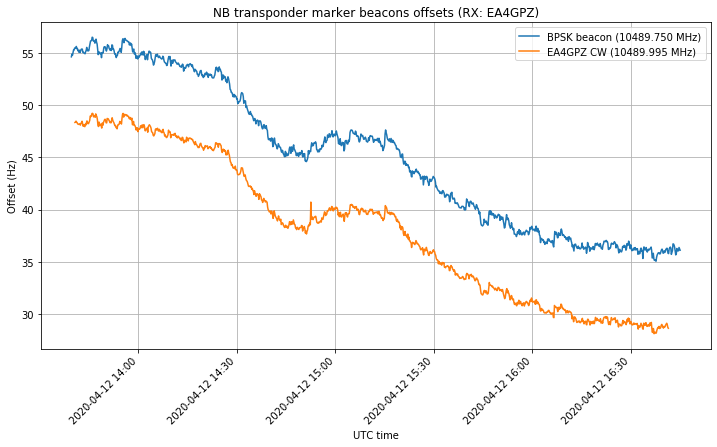

In [8]:
plt.figure(figsize = (12,6), facecolor = 'w')
bpsk.plot()
ea4gpz_cw.plot()

plt.title('NB transponder marker beacons offsets (RX: EA4GPZ)')
plt.legend(['BPSK beacon (10489.750 MHz)', 'EA4GPZ CW (10489.995 MHz)'])
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.grid()

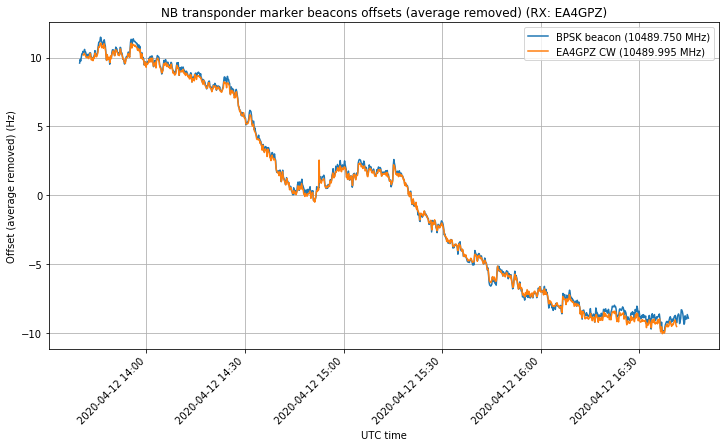

In [9]:
plt.figure(figsize = (12,6), facecolor = 'w')
(bpsk-bpsk.mean()).plot()
(ea4gpz_cw-ea4gpz_cw.mean()).plot()

plt.title('NB transponder marker beacons offsets (average removed) (RX: EA4GPZ)')
plt.legend(['BPSK beacon (10489.750 MHz)', 'EA4GPZ CW (10489.995 MHz)'])
plt.ylabel('Offset (average removed) (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.grid()

In [10]:
bpsk_3b8du = xr.concat((
    load_timeseries('3b8du_phase_bpsk_2020-04-13T08:47:32.740000.f32', freq_tune = -50, skip = 8),
    load_timeseries('3b8du_phase_bpsk_2020-04-13T15:22:18.370000.f32', freq_tune = -50, skip = 8),
    ), 'time')

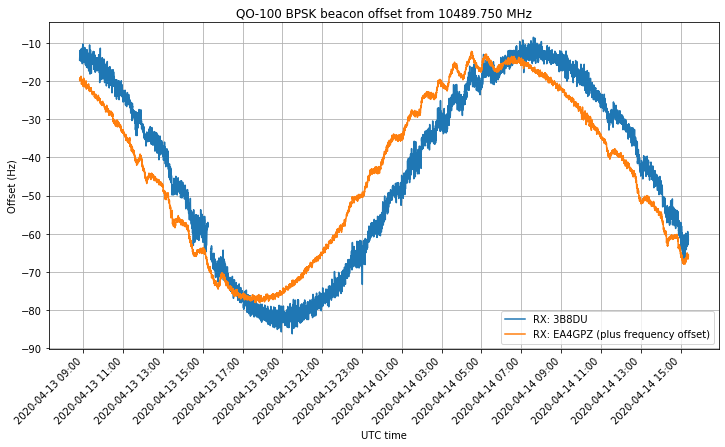

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
f_compare = f.sel(time = slice(bpsk_3b8du.time[0], bpsk_3b8du.time[-1]))
f_diff = bpsk_3b8du - f_compare.interp(time = bpsk_3b8du.time)
bpsk_3b8du.plot(label = 'RX: 3B8DU')
(f_compare+f_diff.mean()).plot(label = 'RX: EA4GPZ (plus frequency offset)')
plt.title('QO-100 BPSK beacon offset from 10489.750 MHz')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.grid()
plt.legend();

In [ ]:
plt.figure(figsize = (12,6), facecolor = 'w')
f_diff.plot(label = '3B8DU - EA4GPZ')
ax1 = plt.gca()
ax2 = plt.gca().twinx()
f_compare.plot(ax = ax2, color = 'grey', label = 'EA4GPZ', alpha = 0.5);
plt.title('Frequency difference 3B8DU - EA4GPZ')
ax1.set_ylabel('3B8DU - EA4GPZ (Hz)', color = 'C0')
ax2.set_ylabel('EA4GPZ (Hz)', color = 'grey')
ax1.set_xlabel('UTC time')
plt.xticks(rotation = 45)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval = 2))
ax1.grid()

In [ ]:
engineering = load_timeseries('phase_10706MHz_2020-04-14T19:29:35.979204.f32', freq_tune = -460, skip = 1)

plt.figure(figsize = (12,6), facecolor = 'w')
engineering.plot()
plt.title('Engineering beacon offset from 10706 MHz (V pol) (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,3)))
plt.grid()

In [ ]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = 0

for j,d in enumerate(engineering.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    plt.plot(time_of_day, d[1] - offset_by_day*j, label = d[0].astype('datetime64[D]'))

plt.title('Engineering beacon offset from 10706 MHz (V pol) (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = -5

for j,d in enumerate(engineering.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    plt.plot(time_of_day, d[1] - offset_by_day*j, label = d[0].astype('datetime64[D]'))

plt.title('Engineering beacon offset from 10706 MHz (V pol) (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = 0

for j,d in enumerate(f.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    label = {'label' : 'BPSK beacon'} if j == 0 else {}
    plt.plot(time_of_day, d[1] - offset_by_day*j - f.mean(), color = 'C0', **label)

for j,d in enumerate(engineering.resample(time = '1d')):
    time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
    label = {'label' : 'Engineering beacon (-7Hz offset)'} if j == 0 else {}
    plt.plot(time_of_day, d[1] - offset_by_day*j - engineering.mean() - 7, color = 'C1', **label)

plt.title('Engineering and BPSK beacon doppler curves (RX: EA4GPZ)')
plt.ylabel('Offset (average removed) (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend();